In [1]:
import os, sys, time, itertools, pickle
from functools import partial
from scipy import stats
from statsmodels.stats import multitest
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from mpire import WorkerPool

DATA_DIR = "/home/jingbozhou/Project/CombDrug/runAddMut/8-analysis/rawData/"

def readCombData(cancer_type="All"):
    comb_info = pd.read_csv(os.path.join(DATA_DIR, "drug_combination_info.csv"))
    if cancer_type != "All":
        # 'Breast Cancer', 'Colon Cancer', 'Ovarian Cancer',
        # 'Lung Cancer'
        comb_info = comb_info[comb_info["primary_disease"]==cancer_type]
    
    comb_info = comb_info.drop_duplicates(subset=["Drug_row_cid", "Drug_col_cid", "Cell_line_name"]).copy()
    return comb_info

def getMutFeatData(feat_list):
    """
    Return data with have mutation features
    
    :params feat_list: List for mutation type
    
    EX:
    getMutFeatData(["BRCA1_DEL", "TP53_MUT"], cancer_type="Breast Cancer")
    """
    ## Check whether gene_list is list
    if not isinstance(feat_list, list):
        raise ValueError("Please input a list for feat_list params")
    
    feat_data = pd.read_csv(os.path.join(DATA_DIR, "gene_feat_binary.csv"), 
                            index_col="DepMap_ID", 
                            usecols=["DepMap_ID"]+feat_list)
    
    if len(feat_list) > 1:
        feat_data["+".join(feat_list)] = feat_data[feat_list].all(axis=1).astype(int)
        feat_data = feat_data.drop(columns=feat_list)
    
    return feat_data

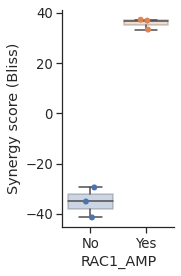

In [2]:
###
cancer_type = "All"
comb_name = "1032350-13-2+Ku-0063794"
feat_name = "RAC1_AMP"
syn_metric_list = ['Bliss']

# Read combination information data
comb_info = readCombData(cancer_type=cancer_type)

# Get drug combination name to cid combination
with open(os.path.join(DATA_DIR, "all_drug_comb_2cid.pickle"), "rb") as f:
    drugcomb2cid = pickle.load(f)
    
drug_1, drug_2 = comb_name.split("+")
if (drug_1, drug_2) in drugcomb2cid:
    cid_1, cid_2 = drugcomb2cid[(drug_1, drug_2)]
else:
    cid_1, cid_2 = drugcomb2cid[(drug_2, drug_1)]
    
#
feat_data = getMutFeatData([feat_name])
    
data = comb_info[((comb_info["Drug_row_cid"]==cid_1)&\
                  (comb_info["Drug_col_cid"]==cid_2))|\
                 ((comb_info["Drug_row_cid"]==cid_2)&\
                  (comb_info["Drug_col_cid"]==cid_1))].copy()
data = data.merge(feat_data, left_on="DepMap_ID", right_on="DepMap_ID")
    
#data = data.replace({feat_name:{0:"No", 1:"Yes"}})
#data

data_sel = data[syn_metric_list+ [feat_name]].melt(id_vars=feat_name,
                                  value_vars=syn_metric_list,
                                  var_name="Synergy_score", value_name='Value')
data_sel = data_sel.replace({feat_name:{0:"No", 1:"Yes"}})

#data_sel = data_sel.round(2)
#data_sel = data_sel.drop_duplicates(subset=["Value"])

sns.set(font_scale=1.2, rc={'figure.figsize':(2,4)}, style="ticks")

ax = sns.boxplot(x=feat_name, y="Value", 
                 data=data_sel, showfliers=False, boxprops={'alpha': 0.3})

sns.stripplot(x=feat_name, y="Value",
              data=data_sel, size=6, linewidth=0, dodge=True, ax=ax)

ax.set(xlabel=feat_name, ylabel="Synergy score ({})".format(syn_metric_list[0]))
#ax.legend(title="", loc=4, frameon=False)
#handles, labels = ax.get_legend_handles_labels()
        
#ax.legend(handles=handles[:2],
             # labels=["Low", "High"],
              #loc=4,
              #title="")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

#plt.savefig('./plotRes/rac1_amp.svg', format='svg',bbox_inches='tight', transparent=True)

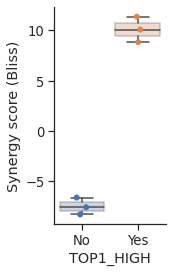

In [4]:
###
cancer_type = "All"
comb_name = "CARBOPLATIN+MK-2206"
feat_name = "TOP1_HIGH"

# Read combination information data
comb_info = readCombData(cancer_type=cancer_type)

# Get drug combination name to cid combination
with open(os.path.join(DATA_DIR, "all_drug_comb_2cid.pickle"), "rb") as f:
    drugcomb2cid = pickle.load(f)
    
drug_1, drug_2 = comb_name.split("+")
if (drug_1, drug_2) in drugcomb2cid:
    cid_1, cid_2 = drugcomb2cid[(drug_1, drug_2)]
else:
    cid_1, cid_2 = drugcomb2cid[(drug_2, drug_1)]
    
#
feat_data = getMutFeatData([feat_name])
    
data = comb_info[((comb_info["Drug_row_cid"]==cid_1)&\
                  (comb_info["Drug_col_cid"]==cid_2))|\
                 ((comb_info["Drug_row_cid"]==cid_2)&\
                  (comb_info["Drug_col_cid"]==cid_1))].copy()
data = data.merge(feat_data, left_on="DepMap_ID", right_on="DepMap_ID")
    
#data = data.replace({feat_name:{0:"No", 1:"Yes"}})
#data

syn_metric_list = ['Bliss']
data_sel = data[syn_metric_list+ [feat_name]].melt(id_vars=feat_name,
                                  value_vars=syn_metric_list,
                                  var_name="Synergy_score", value_name='Value')
data_sel = data_sel.replace({feat_name:{0:"No", 1:"Yes"}})

#data_sel = data_sel.round(2)
#data_sel = data_sel.drop_duplicates(subset=["Value"])

sns.set(font_scale=1.2, rc={'figure.figsize':(2,4)}, style="ticks")

ax = sns.boxplot(x=feat_name, y="Value", 
                 data=data_sel, showfliers=False, boxprops={'alpha': 0.3})

sns.stripplot(x=feat_name, y="Value",
              data=data_sel, size=6, linewidth=0, dodge=True, ax=ax)

ax.set(xlabel=feat_name, ylabel="Synergy score (Bliss)")
#ax.legend(title="", loc=4, frameon=False)
#handles, labels = ax.get_legend_handles_labels()
        
#ax.legend(handles=handles[:2],
             # labels=["Low", "High"],
              #loc=4,
              #title="")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

#plt.savefig('./plotRes/top1_high.svg', format='svg',bbox_inches='tight', transparent=True)

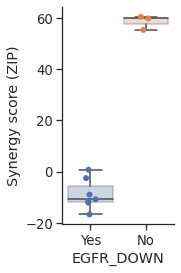

In [5]:
###
cancer_type = "All"
comb_name = "SMI-4a+RUXOLITINIB"
feat_name = "EGFR_DOWN"

# Read combination information data
comb_info = readCombData(cancer_type=cancer_type)

# Get drug combination name to cid combination
with open(os.path.join(DATA_DIR, "all_drug_comb_2cid.pickle"), "rb") as f:
    drugcomb2cid = pickle.load(f)
    
drug_1, drug_2 = comb_name.split("+")
if (drug_1, drug_2) in drugcomb2cid:
    cid_1, cid_2 = drugcomb2cid[(drug_1, drug_2)]
else:
    cid_1, cid_2 = drugcomb2cid[(drug_2, drug_1)]
    
#
feat_data = getMutFeatData([feat_name])
    
data = comb_info[((comb_info["Drug_row_cid"]==cid_1)&\
                  (comb_info["Drug_col_cid"]==cid_2))|\
                 ((comb_info["Drug_row_cid"]==cid_2)&\
                  (comb_info["Drug_col_cid"]==cid_1))].copy()
data = data.merge(feat_data, left_on="DepMap_ID", right_on="DepMap_ID")
    
#data = data.replace({feat_name:{0:"No", 1:"Yes"}})

syn_metric_list = ['ZIP']
data_sel = data[syn_metric_list+ [feat_name]].melt(id_vars=feat_name,
                                  value_vars=syn_metric_list,
                                  var_name="Synergy_score", value_name='Value')
data_sel = data_sel.replace({feat_name:{0:"No", 1:"Yes"}})

#data_sel = data_sel.round(2)
#data_sel = data_sel.drop_duplicates(subset=["Value"])

sns.set(font_scale=1.2, rc={'figure.figsize':(2,4)}, style="ticks")

ax = sns.boxplot(x=feat_name, y="Value", 
                 data=data_sel, showfliers=False, boxprops={'alpha': 0.3})

sns.stripplot(x=feat_name, y="Value",
              data=data_sel, size=6, linewidth=0, dodge=True, ax=ax)

ax.set(xlabel=feat_name, ylabel="Synergy score (ZIP)")
#ax.legend(title="", loc=4, frameon=False)
#handles, labels = ax.get_legend_handles_labels()
        
#ax.legend(handles=handles[:2],
             # labels=["Low", "High"],
              #loc=4,
              #title="")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

#plt.savefig('./plotRes/EGFR_low.svg', format='svg',bbox_inches='tight', transparent=True)